# DS 3000: UG Group Project Part 2

## 2a. Regularized Elastic Net Linear Regression

In [12]:
# Import packages
import polars as pl
import pandas as pd 

import os
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold


In [2]:
# Load datasets
demo = pl.read_csv("DemoStats.csv")
spend = pl.read_csv("HouseholdSpend.csv")

In [3]:
demo.head()

CODE,GEO,ECYASQKM,ECYALSQKM,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,…,ECYRIMINDI,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""A0A0A0""","""FSALDU""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""A0A1A0""","""FSALDU""",0,0,55,33,55,55,55,55,55,55,55,55,55,0,20,17,17,4,24,55,0,0,0,0,0,0,0,0,0,4,2,7,7,15,14,…,0,0,0,0,0,0,0,0,55,55,0,0,0,0,0,0,0,55,55,0,0,0,0,0,0,0,55,0,0,55,55,55,0,55,0,0,0
"""A0A1B0""","""FSALDU""",0,0,588,243,588,561,512,475,475,513,512,475,475,38,280,172,168,136,264,588,15,12,49,37,19,37,8,35,29,45,30,57,39,43,59,…,0,0,0,0,0,0,0,0,588,577,11,3,2,0,0,6,0,588,577,11,0,1,1,5,4,0,588,11,14,563,588,587,113,474,1,0,1
"""A0A1C0""","""FSALDU""",0,0,1793,709,1791,1548,1465,1405,1395,1495,1463,1408,1396,87,935,560,543,491,958,1793,98,127,103,79,90,81,110,111,116,132,107,140,138,148,91,…,0,0,0,2,0,0,0,0,1791,1741,40,21,2,0,0,17,10,1791,1741,40,4,2,21,12,1,10,1791,50,32,1709,1791,1776,380,1396,15,3,12
"""A0A1E0""","""FSALDU""",0,0,452,176,449,415,389,357,357,389,386,354,354,35,211,132,130,121,200,452,20,16,27,32,24,18,27,32,21,17,27,21,48,29,35,…,0,0,0,0,0,0,0,0,449,439,9,5,2,0,0,2,1,449,439,9,2,0,4,3,0,1,449,10,14,425,449,446,95,351,3,0,3


In [4]:
spend.head()

CODE,GEO,HSBASHHD,HSHNIAGG,HSAGDISPIN,HSAGDISCIN,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,HSSH053,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""A0A0A0""","""FSALDU""",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""A0A1A0""","""FSALDU""",33,2.2816e6,1.8717e6,1.4445e6,2.5887e6,2.3359e6,315297.596331,1.8692e6,257646.494751,354957.422972,144484.959469,187320.826105,92368.078197,418182.769335,84593.699721,41802.878965,64226.330794,10445.26236,5742.21909,133264.292457,41868.872993,32247.312836,91262.7156,60191.791896,252762.521224,139152.204852,5031.031467,97662.961189,-332.925616,11249.249331,257646.494751,187182.804022,11341.700802,11338.41255,11336.953667,…,377880.544471,157694.431895,154618.605589,19147.601315,6506.452965,128964.551309,92.981121,27.22591,65.755211,2982.845186,2915.093273,1717.740721,1197.352552,67.751913,1125.909986,219060.202589,3580.014342,14610.543963,16914.182572,33419.733884,152.944603,146687.301129,1981.620945,888.522083,825.339069,278.449988,546.889081,40302.224863,224.75766,657.334582,4139.93137,32857.110603,20.511766,1694.913488,1132.355623,562.557865,707.665394
"""A0A1B0""","""FSALDU""",243,1.8653e7,1.4910e7,1.0829e7,2.0953e7,1.9627e7,2.6028e6,1.5574e7,2.6880e6,2.9052e6,1.1747e6,1.3958e6,704122.010242,3.2557e6,703010.071684,363644.570932,592534.770767,179153.75606,34377.860105,1.0541e6,269744.720161,253401.496087,1.1146e6,336215.258581,1.3254e6,777722.81311,26446.742904,320067.799042,109613.380836,91517.204431,2.6880e6,2.0889e6,296911.75143,292965.218012,291925.832842,…,2.9270e6,1.3666e6,1.3347e6,144905.233034,70969.3071,1.1188e6,1572.569428,635.322319,937.247109,30301.802001,29648.970902,16628.734678,13020.236224,652.831098,8739.128845,1.5517e6,28991.087452,129798.731751,149304.455577,175778.498143,928.548736,1.0321e6,12730.15919,8537.751987,13519.780259,2539.210274,10980.569985,328744.754734,4252.18577,11548.167172,21551.193368,269365.223196,256.084243,12084.581078,8089.461528,3995.11955,9687.319907
"""A0A1C0""","""FSALDU""",709,7.7912e7,5.9097e7,4.3587e7,8.6534e7,8.0168e7,1.4246e7,6.0199e7,1.1291e7,1.0552e7,4.5107e6,4.6035e6,3.0758e6,1.2234e7,3.0064e6,1.4868e6,2.4299e6,739781.043919,138558.624294,4.2226e6,887965.79594,1.0206e6,4.4827e6,1.2403e6,6.3658e6,2.8902e6,113044.118637,2.5191e6,469245.349471,374214.83051,1.1291e7,8.5885e6,881199.703655,875858.059795,873266.174238,…,1.0800e7,5.5292e6,5.3760e6,504651.039362,274340.95416,4.5970e6,6165.60132,2730.643738,3434.957582,147062.40254,144332.340337,77036.265539,67296.074799,2730.062203,46291.892482,5.2241e6,94851.316536,463399.883939,470456.016644,560144.196807,4217.064428,3.4998e6,46901.967628,39916.485144,44493.479726,7988.469942,36505.009784,1.4339e6,14661.222551,51334.803379,72033.951513,1.2090e6,797.686509,47442.041806,31659.420678,15782.621128,38636.01747
"""A0A1E0""","""FSALDU""",176,1.5689e7,1.2246e7,8.9893e6,1.7649e7,1.6302e7,2.5344e6,1.2629e7,2.2189e6,2.2942e6,996736.661623,1.1100e6,610914.215686,2.6495e6,583192.907194,298119.500345,475823.

In [5]:
demo.describe()

statistic,CODE,GEO,ECYASQKM,ECYALSQKM,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,…,ECYRIMINDI,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""868970""","""868970""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,0.0,0.0,46.684199,18.432629,45.881762,41.254934,39.613594,37.819792,37.323999,40.336732,38.832472,37.263988,36.746572,3.072744,24.49923,12.76093,12.051364,12.740845,24.633679,46.684199,2.181318,2.390635,2.498651,2.672259,3.213171,3.308621,3.406466,3.258362,3.117668,2.858167,2.776588,2.859335,3.10898,2.80384,…,0.477122,0.005692,0.038764,0.008754,0.00028,0.007272,0.005106,0.002166,45.881762,31.717238,11.757474,4.721479,2.368195,1.391643,1.640656,1.635501,2.407051,45.881762,31.717238,11.757474,1.066154,2.036562,2.230265,5.299374,1.125119,2.407051,45.881762,14.168175,7.448384,24.265204,45.881762,40.528679,7.761493,32.767185,5.353084,0.85628,4.496803
"""std""",null,null,0.0,0.0,174.837877,69.379951,171.817976,152.539099,145.876662,139.320601,137.611402,149.038058,143.038376,137.181937,135.319262,12.468123,87.647782,50.126862,47.828225,49.02113,89.352097,174.837877,9.518254,10.400337,10.705186,10.30089,10.888878,10.894537,11.699239,11.371185,11.099312,10.485757,10.544898,11.657788,13.69638,12.729886,…,2.516032,0.123928,0.364373,0.142995,0.02439,0.118581,0.094428,0.057987,171.817976,149.721097,32.868441,14.28478,7.28958,4.605282,5.813031,5.761745,10.479555,171.817976,149.721097,32.868441,3.400699,6.112712,6.550715,14.905824,3.936661,10.479555,171.817976,40.185434,24.588753,131.818196,171.817976,163.866165,34.782061,130.449848,17.893635,3.211073,15.020402
"""min""","""A0A0A0""","""FSALDU""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",null,null,0.0,0.0,8.0,3.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,0.0,4.0,2.0,2.0,2.0,4.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,

In [6]:
spend.describe()

statistic,CODE,GEO,HSBASHHD,HSHNIAGG,HSAGDISPIN,HSAGDISCIN,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""868970""","""868970""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,18.432629,2.2534e6,1.7170e6,1.2342e6,2.4008e6,2.1917e6,421335.834661,1.6065e6,388812.651163,278016.994627,111401.557243,109343.827301,76103.411113,271135.371662,87929.804561,45315.650319,70798.452452,34398.504565,3570.867859,70468.350013,25849.158365,33310.372386,115213.19111,48732.91062,209040.481816,67544.21004,4806.924846,112565.256385,15089.24985,9034.840695,388812.651163,303764.492909,89251.190609,88053.450315,…,236398.761036,118477.006209,114562.677761,14888.288571,8607.895903,91066.493288,188.957063,83.539013,105.41805,3725.371385,3469.552047,2092.59778,1376.954267,255.819338,1504.664209,116417.090618,3287.664753,10103.061471,12676.188385,18214.142317,100.530695,63415.559732,2639.560863,4612.181943,1368.200459,379.01064,989.189819,34736.610626,5995.306708,2258.469958,915.416319,23038.220756,71.1409,1322.434304,831.592595,490.84171,1135.621681
"""std""",null,null,69.379951,8.2787e6,6.3276e6,4.6340e6,9.1329e6,8.0562e6,1.5969e6,5.9255e6,1.3661e6,1.0471e6,420881.63654,429642.774397,290959.592849,1.0751e6,327376.60947,163377.943862,249311.269506,114999.916794,14386.745375,264786.580294,94955.831503,127397.296924,431645.982804,206454.726959,1.2713e6,341440.420828,40531.631801,898861.389623,51492.602769,35858.838458,1.3661e6,1.0270e6,292325.224526,287942.333453,…,990960.632583,507452.95803,494184.487741,58848.760548,45895.371562,398856.15598,794.022208,358.55285,497.256289,14112.764792,13213.369738,8173.498909,5705.767025,1422.161917,5673.303299,486744.921092,14400.182837,39378.141535,60281.31644,71889.568827,615.785308,284702.777168,13567.714202,14917.235034,5725.037991,2091.296014,3882.026395,101629.434794,19414.670337,7613.821326,5037.673958,71509.135272,257.018871,6638.799848,5076.885882,2097.649493,4203.801021
"""min""","""A0A0A0""","""FSALDU""",0.0,0.0,0.0,0.0,-24249.492537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4599e7,0.0,0.0,-1.6806e7,-26676.98553,-204380.698719,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [5]:
################### PREPROCESSING ##################

# Merge on "CODE" and "GEO"
data = demo.join(spend, on=["CODE", "GEO"], how="inner")

# Drop identifier columns
data = data.drop(["CODE", "GEO"])


In [8]:
data.describe()

statistic,ECYASQKM,ECYALSQKM,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.0,0.0,46.684199,18.432629,45.881762,41.254934,39.613594,37.819792,37.323999,40.336732,38.832472,37.263988,36.746572,3.072744,24.49923,12.76093,12.051364,12.740845,24.633679,46.684199,2.181318,2.390635,2.498651,2.672259,3.213171,3.308621,3.406466,3.258362,3.117668,2.858167,2.776588,2.859335,3.10898,2.80384,2.278714,1.770631,…,236398.761036,118477.006209,114562.677761,14888.288571,8607.895903,91066.493288,188.957063,83.539013,105.41805,3725.371385,3469.552047,2092.59778,1376.954267,255.819338,1504.664209,116417.090618,3287.664753,10103.061471,12676.188385,18214.142317,100.530695,63415.559732,2639.560863,4612.181943,1368.200459,379.01064,989.189819,34736.610626,5995.306708,2258.469958,915.416319,23038.220756,71.1409,1322.434304,831.592595,490.84171,1135.621681
"""std""",0.0,0.0,174.837877,69.379951,171.817976,152.539099,145.876662,139.320601,137.611402,149.038058,143.038376,137.181937,135.319262,12.468123,87.647782,50.126862,47.828225,49.02113,89.352097,174.837877,9.518254,10.400337,10.705186,10.30089,10.888878,10.894537,11.699239,11.371185,11.099312,10.485757,10.544898,11.657788,13.69638,12.729886,10.420684,8.140557,…,990960.632583,507452.95803,494184.487741,58848.760548,45895.371562,398856.15598,794.022208,358.55285,497.256289,14112.764792,13213.369738,8173.498909,5705.767025,1422.161917,5673.303299,486744.921092,14400.182837,39378.141535,60281.31644,71889.568827,615.785308,284702.777168,13567.714202,14917.235034,5725.037991,2091.296014,3882.026395,101629.434794,19414.670337,7613.821326,5037.673958,71509.135272,257.018871,6638.799848,5076.885882,2097.649493,4203.801021
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,8.0,3.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,0.0,4.0,2.0,2.0,2.0,4.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

In [6]:
# Create target variable
col_income = "HSHNIAGG" # column for disposable income
col_insur = "HSEP001S" # column for insurance + pension

# !!!!!!!!!!! I decided to drop data with disposable income of 0 for now but we might need to discuss 
data = data.filter(pl.col(col_income) > 0)

# Calculate proportions and create a new column for it
data = data.with_columns(
    (pl.col(col_insur) / pl.col(col_income)).alias("PROP_IIP") # Short for Proportion Income spent on Insurance and Pensions
)

# Drop used components
data = data.drop([col_income, col_insur])

In [7]:
# Drop some more
data = data.drop([
    "HSAGDISPIN", "HSAGDISCIN"
])

In [8]:
# Drop columns that are strings or categorical
data = data.drop([
    col for col, dtype in zip(data.columns, data.dtypes)
    if dtype in [pl.Utf8, pl.Categorical]
])

In [9]:
# Split train test 
X_train, X_test, y_train, y_test = train_test_split(data.drop("PROP_IIP"), data["PROP_IIP"], test_size=0.3)


In [13]:
data.describe()

statistic,ECYASQKM,ECYALSQKM,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,…,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057,PROP_IIP
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,…,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0,776261.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.0,0.0,51.86496,20.634042,51.36143,45.790484,43.954013,41.951247,41.398036,45.154156,43.470241,41.714434,41.135223,3.439722,27.425178,14.28497,13.490661,14.262486,27.575684,51.86496,2.440477,2.674769,2.795701,2.982636,3.585459,3.692721,3.803069,3.637652,3.48111,3.191628,3.099434,3.189265,3.464498,3.122321,2.528821,1.948229,…,132626.737767,128244.920322,16666.399728,9635.93856,101942.582034,211.524241,93.516094,118.008148,4170.293204,3883.921313,2342.517134,1541.40418,286.37189,1684.366544,130320.806062,3680.311185,11309.672039,14190.107993,20389.460825,112.537095,70989.292184,2954.804123,5163.015716,1531.604902,424.275953,1107.328949,38885.21069,6711.327337,2528.199458,1024.744665,25789.679876,79.637272,1480.372887,930.909857,549.463029,1271.249196,0.053749
"""std""",0.0,0.0,184.06393,73.096106,181.013055,160.527529,153.493914,146.585083,144.785132,156.99568,150.671543,144.501839,142.540168,13.143733,92.300427,52.830146,50.411543,51.656252,94.107263,184.06393,10.038313,10.968116,11.288645,10.825614,11.407326,11.450808,12.306138,11.963256,11.682477,11.04083,11.106779,12.284857,14.438684,13.423878,10.977724,8.537493,…,535150.632192,521182.026216,62025.400027,48456.632839,420686.604205,837.254536,378.128431,524.69885,14869.486565,13922.48107,8613.902544,6015.849148,1501.781711,5977.266487,513229.172749,15188.347775,41499.215403,63610.886042,75769.292283,650.482402,300330.69034,14322.585869,15692.547287,6036.575586,2208.312681,4091.349482,106774.360043,20424.024595,8013.223716,5319.496913,75188.502425,270.687061,7007.395235,5362.891425,2212.110431,4428.328431,0.015789
"""min""",0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,1.256321,1.192825,0.48029,0.099021,0.613514,0.012459,0.008932,0.000586,0.051036,0.046728,0.046219,0.000508,0.001539,0.018654,4.346338,0.184241,0.518425,0.674086,0.587845,0.002327,1.851796,0.016411,0.047549,0.217365,0.047833,0.110168,1.371199,0.032134,0.224306,0.026282,

In [14]:
# Grid I chose
l1_ratios = [0.1, 0.3, 0.5]
alphas = [0.001, 0.01, 0.1]

# Create a pipeline with scaler and enet obj
elastic_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("enet", ElasticNetCV(
        l1_ratio=l1_ratios,  
        alphas=alphas,  
        cv=3,
        max_iter=10000,
        n_jobs=1
    ))
])

# train the pipe
elastic_pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('enet',
                 ElasticNetCV(alphas=[0.001, 0.01, 0.1], cv=3,
                              l1_ratio=[0.1, 0.3, 0.5], max_iter=10000,
                              n_jobs=1))])

In [20]:
# best params
best_alpha = elastic_pipe.named_steps["enet"].alpha_
best_l1_ratio = elastic_pipe.named_steps["enet"].l1_ratio_

print("Best params:")
print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

Best params:
Best alpha: 0.001
Best l1_ratio: 0.1


In [15]:
# Predict
y_pred = elastic_pipe.predict(X_test)



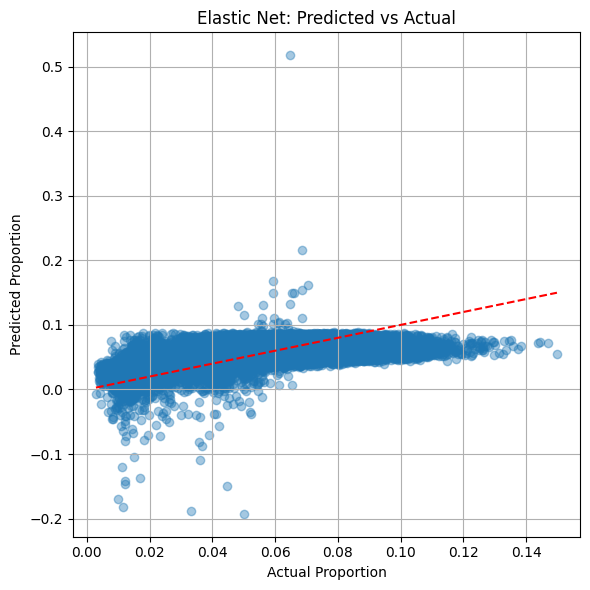

In [21]:
# Display figure
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Proportion")
plt.ylabel("Predicted Proportion")
plt.title("Elastic Net: Predicted vs Actual")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 1:1 line
plt.tight_layout()
plt.show()

In [24]:
# MSE and R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R squared: {r2:.4f}")

# BOOTSTRAP





MSE: 0.0001
R squared: 0.4286


In [25]:
# coeffs
coefs = elastic_pipe.named_steps["enet"].coef_
features = X_train.columns

coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefs
})

# Sort by absolute magnitude
top5 = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(5)
print(top5)

        Feature  Coefficient
148   ECYMTNAVG    -0.008284
278  ECYHNI200P    -0.002619
277  ECYHNIX200     0.002379
265   ECYHRIAVG    -0.002129
355  ECYINDPUBL     0.001626


## 2b. XGB

In [ ]:
# Data Prep (if necessary)

#

In [ ]:
# Define the hyperparameter grid for XGBoost
param_grid_xgb = {
    "n_estimators":[100, 150, 200], 
    "max_depth":[2, 3, 5], 
    "learning_rate":[0.01, 0.05, 0.1]}

# Initialize the XGBoost regressor
positive_weight = y_train.to_pandas().value_counts().iloc[0] / y_train.to_pandas().value_counts().iloc[1]
print(f"positive weight is: {positive_weight:.3}")
XGB_Placement = XGBRegressor(n_estimator=1, # Overriden by GridSearch
                              max_depth=3, # Overriden by GridSearch
                              learning_rate=0.1, # Overriden by GridSearch
                              verbosity=1,
                              objectivity='reg:squarederror',
                              booster='gbtree',
                              n_jobs=1,
                              gamma=0.001,
                              subsample=0.632,
                              colsample_bytree=1,
                              colsample_bylevel=1,
                              colsample_bynode=1,
                              scale_pos_weight=positive_weight,
                              base_score=0.5
                              )

# 5 fold CV object for grid search
cv_obj = KFold(n_splits = 5, shuffle = True)

# Apply Grid Search only for Random Forest
GridXGB = GridSearchCV(
    XGB_Placement, param_grid_xgb, cv=cv_obj, scoring='neg_mean_squared_error', verbose=1, n_jobs=1
)

# Train the model
GridXGB.fit(X_train, y_train)


positive weight is: 1.0
Fitting 5 folds for each of 27 candidates, totalling 135 fits


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x00000169B55B8B50>>
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 585, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 
